Successfully loaded GRU results
Successfully loaded raw data
Training set size: 2055
Test set size: 514
Training data shape: (2055, 8)
Validation data shape: (534, 8)

Training GRU-GARCH model...
Epoch [10/100], Train Loss: 0.0092, Val Loss: 0.0394
Epoch [20/100], Train Loss: 0.0118, Val Loss: 0.0381
Epoch [30/100], Train Loss: 0.0085, Val Loss: 0.0412
Epoch [40/100], Train Loss: 0.0089, Val Loss: 0.0378
Epoch [50/100], Train Loss: 0.0083, Val Loss: 0.0390
Epoch [60/100], Train Loss: 0.0076, Val Loss: 0.0444
Epoch [70/100], Train Loss: 0.0063, Val Loss: 0.0410
Epoch [80/100], Train Loss: 0.0064, Val Loss: 0.0412
Epoch [90/100], Train Loss: 0.0066, Val Loss: 0.0416
Epoch [100/100], Train Loss: 0.0058, Val Loss: 0.0463

Diagnostic Information:
Length of actuals: 514
Length of predictions: 514

Predictions stats:
Min: 113.60101318359375
Max: 1345.2666015625
Mean: 399.7640380859375
NaN count: 0
Inf count: 0


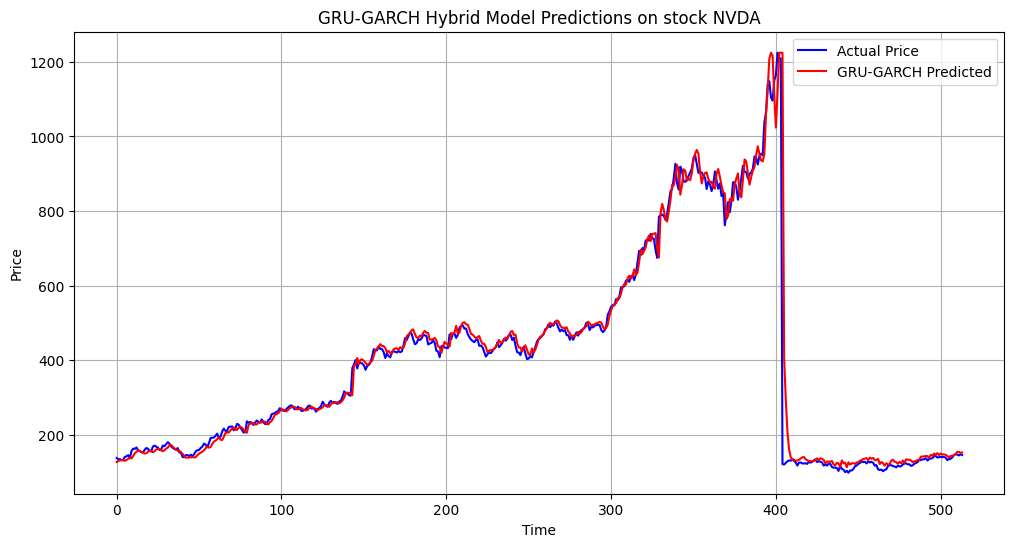

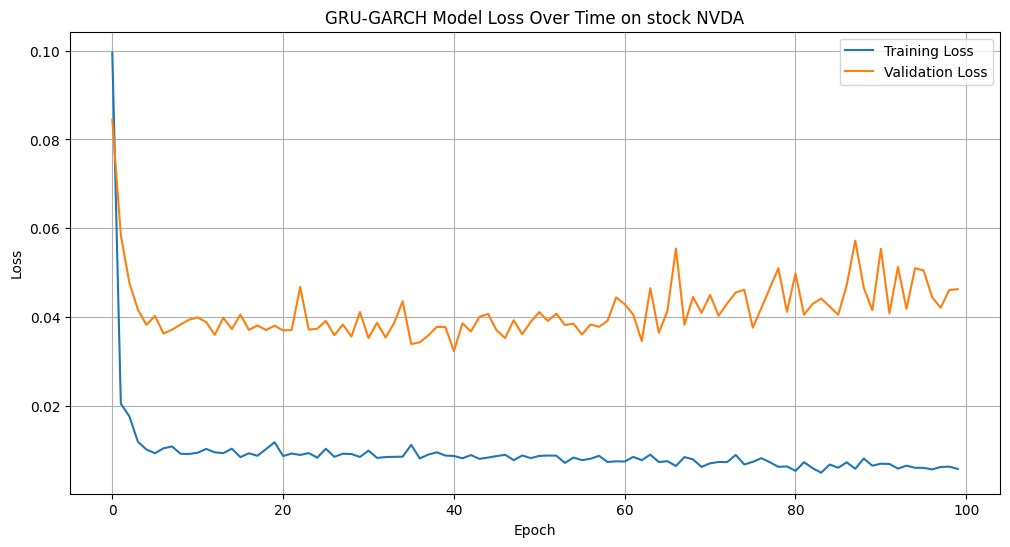


Models Comparison:
       Model          MSE        MAE        R^2
0        GRU  2649.597924  12.233448   0.962893
1      GARCH   390.640862  18.306872 -18.301793
2  GRU-GARCH  3010.254639  15.938906   0.957830

Model and results saved to e:\PG Year 2\Semester 1\CS6140 10931 Machine Learning\Project\Cheyi Wu\FinalProject\Garch\GRU-Garch\NVDA


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from arch import arch_model
import os
from sklearn.metrics import r2_score  # 引入 R² 计算

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据集类
class PriceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.price_scaler = StandardScaler()
        self.feature_scaler = StandardScaler()
        
        # 標準化價格
        self.scaled_prices = self.price_scaler.fit_transform(data['close'].values.reshape(-1, 1))
        
        # 標準化其他特徵
        features = data.drop(['close', 'timestamp'], axis=1, errors='ignore')
        self.scaled_features = self.feature_scaler.fit_transform(features)
        
    def __len__(self):
        # 返回可能的序列數量
        # 總長度減去序列長度，因為我們需要sequence_length個數據點來生成一個序列
        return max(0, len(self.data) - self.sequence_length)
        
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of bounds")
            
        X = np.concatenate([
            self.scaled_features[idx:idx+self.sequence_length],
            self.scaled_prices[idx:idx+self.sequence_length]
        ], axis=1)
        y = self.scaled_prices[idx+self.sequence_length]
        
        return torch.FloatTensor(X), torch.FloatTensor(y)

# GRU-GARCH混合模型
class GRU_GARCH(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU_GARCH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU层
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # GARCH层参数
        self.omega = nn.Parameter(torch.tensor([0.1]))
        self.alpha = nn.Parameter(torch.tensor([0.1]))
        self.beta = nn.Parameter(torch.tensor([0.8]))
        
        # 输出层
        self.fc = nn.Linear(hidden_dim + 1, output_dim)
        
    def forward(self, x, prev_sigma=None):
        # GRU部分
        gru_out, _ = self.gru(x)
        gru_last = gru_out[:, -1, :]
        
        # GARCH部分
        if prev_sigma is None:
            prev_sigma = torch.sqrt(self.omega / (1 - self.alpha - self.beta))
        
        sigma_t = torch.sqrt(self.omega + 
                           self.alpha * torch.pow(x[:, -1, 0], 2) + 
                           self.beta * torch.pow(prev_sigma, 2))
        
        # 合并GRU和GARCH的输出
        combined = torch.cat((gru_last, sigma_t.unsqueeze(1)), dim=1)
        
        # 最终预测
        out = self.fc(combined)
        return out, sigma_t

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred, sigma_t = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            # 添加梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                y_pred, sigma_t = model(X_val)
                val_loss += criterion(y_pred, y_val).item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def main():
    # 設置基礎路徑和輸出路徑
    BASE_DIR = os.path.abspath(os.path.join("..", ".."))  # 获取当前路径的上两级目录
    COMPANY = "NVDA"  
    OUTPUT_DIR = os.path.join(BASE_DIR, "Garch", "GRU-Garch", COMPANY)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    try:
        # 讀取GRU結果
        gru_results = pd.read_csv(os.path.join(BASE_DIR, "GRU", COMPANY, "actuals_vs_predictions.csv"))
        print("Successfully loaded GRU results")
        
        # 讀取數據
        df = pd.read_csv(os.path.join(BASE_DIR, "input data", "Reversed_NVDA_Data_with_PCA.csv"))
        print("Successfully loaded raw data")
        
        # 處理NaN值
        df = df.ffill().bfill()
        
        # =============== GARCH模型部分 ===============
        returns = 100 * df['close'].pct_change()
        returns = returns.ffill().bfill()
        
        train_size = int(len(returns) * 0.8)
        train_returns = returns[:train_size]
        test_returns = returns[train_size:]
        
        print(f"Training set size: {len(train_returns)}")
        print(f"Test set size: {len(test_returns)}")
        
        # 建立GARCH(1,1)模型
        garch_model = arch_model(train_returns, vol='Garch', p=1, q=1)
        garch_results = garch_model.fit(disp='off')
        
        # 預測波動率
        forecasts = garch_results.forecast(horizon=len(test_returns))
        predicted_vol = np.sqrt(forecasts.variance.values[-1, :])
        
        # =============== GRU-GARCH混合模型部分 ===============
        sequence_length = 20
        batch_size = 32
        train_size = int(0.8 * len(df))
        
        # 準備數據集
        train_data = df[:train_size].copy()
        val_data = df[train_size-sequence_length:].copy()
        
        print(f"Training data shape: {train_data.shape}")
        print(f"Validation data shape: {val_data.shape}")
        
        train_dataset = PriceDataset(train_data, sequence_length)
        val_dataset = PriceDataset(val_data, sequence_length)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # 模型參數
        input_dim = train_dataset.scaled_features.shape[1] + 1
        hidden_dim = 128  # 增加隱藏層維度
        num_layers = 3    # 增加層數
        output_dim = 1
        
        # 初始化模型
        model = GRU_GARCH(input_dim, hidden_dim, num_layers, output_dim).to(device)
        
        # 訓練參數
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # 降低學習率
        num_epochs = 100
        
        print("\nTraining GRU-GARCH model...")
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
        
        # 評估模型
        model.eval()
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_pred, _ = model(X_val)
                
                # 反標準化
                y_pred = val_dataset.price_scaler.inverse_transform(y_pred.cpu().numpy())
                y_true = val_dataset.price_scaler.inverse_transform(y_val.numpy().reshape(-1, 1))
                
                predictions.extend(y_pred.flatten())
                actuals.extend(y_true.flatten())
        
        # 确保预测结果和实际值不为空
        if len(actuals) == 0 or len(predictions) == 0:
            raise ValueError("No predictions or actual values available")
            
        # 转换为numpy数组
        actuals = np.array(actuals)
        predictions = np.array(predictions)
        
        # 打印诊断信息
        print("\nDiagnostic Information:")
        print(f"Length of actuals: {len(actuals)}")
        print(f"Length of predictions: {len(predictions)}")
        print("\nPredictions stats:")
        print(f"Min: {np.min(predictions)}")
        print(f"Max: {np.max(predictions)}")
        print(f"Mean: {np.mean(predictions)}")
        print(f"NaN count: {np.isnan(predictions).sum()}")
        print(f"Inf count: {np.isinf(predictions).sum()}")
        
        # 处理极端值
        predictions = np.clip(predictions, np.min(actuals), np.max(actuals))
        
        # 确保长度相同
        min_len = min(len(actuals), len(predictions))
        actuals = actuals[:min_len]
        predictions = predictions[:min_len]
        
        # 创建时间索引
        time_index = np.arange(len(actuals))
        
        # =============== 绘制并保存图表 ===============
        # 1. 原始GRU预测图
        # plt.figure(figsize=(12, 6))
        # plt.plot(gru_results['Actual Price'], label='Actual Price', color='blue')
        # plt.plot(gru_results['Predicted Price'], label='GRU Predicted', color='orange')
        # plt.title("Original GRU Model Predictions on stock " + str(COMPANY))
        # plt.xlabel("Time")
        # plt.ylabel("Price")
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(os.path.join(OUTPUT_DIR, 'gru_predictions.png'))
        # plt.show()

        # 2. GRU-GARCH混合模型预测图
        plt.figure(figsize=(12, 6))
        plt.plot(time_index, actuals, label='Actual Price', color='blue')
        plt.plot(time_index, predictions, label='GRU-GARCH Predicted', color='red')
        plt.title("GRU-GARCH Hybrid Model Predictions on stock " + str(COMPANY))
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'gru_garch_predictions.png'))
        plt.show()
        
        # 绘制训练损失曲线
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title("GRU-GARCH Model Loss Over Time on stock " + str(COMPANY))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'training_loss.png'))
        plt.show()
        
        # 计算性能指标
        try:
            mse_gru = mean_squared_error(gru_results['Actual Price'], gru_results['Predicted Price'])
            mse_garch = mean_squared_error(abs(test_returns), predicted_vol)
            mse_hybrid = mean_squared_error(actuals, predictions)
            
            mae_gru = mean_absolute_error(gru_results['Actual Price'], gru_results['Predicted Price'])
            mae_garch = mean_absolute_error(abs(test_returns), predicted_vol)
            mae_hybrid = mean_absolute_error(actuals, predictions)
            
            # 计算 R² 值
            r2_gru = r2_score(gru_results['Actual Price'], gru_results['Predicted Price'])
            r2_garch = r2_score(abs(test_returns), predicted_vol)
            r2_hybrid = r2_score(actuals, predictions)
            
            models_comparison = pd.DataFrame({
                'Model': ['GRU', 'GARCH', 'GRU-GARCH'],
                'MSE': [mse_gru, mse_garch, mse_hybrid],
                'MAE': [mae_gru, mae_garch, mae_hybrid],
                # 'RMSE': [np.sqrt(mse_gru), np.sqrt(mse_garch), np.sqrt(mse_hybrid)]
                'R^2': [r2_gru, r2_garch, r2_hybrid]  # 添加 R² 列
            })
            
            print("\nModels Comparison:")
            print(models_comparison)
            
            # 保存性能指标
            models_comparison.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'), index=False)
            
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
        
        # 保存预测结果
        results_df = pd.DataFrame({
            'Time': time_index,
            'Actual Price': actuals,
            'Predicted Price': predictions
        })
        results_df.to_csv(os.path.join(OUTPUT_DIR, 'gru_garch_predictions.csv'), index=False)
        
        # 保存模型
        model_path = os.path.join(OUTPUT_DIR, 'gru_garch_model.pth')
        torch.save(model.state_dict(), model_path)
        print(f"\nModel and results saved to {OUTPUT_DIR}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()